## mpg 예측 모델 구현 <hr>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import callbacks 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample

In [2]:
data_file = '../DATA/auto-mpg.csv'

In [3]:
mpgDF = pd.read_csv(data_file)
mpgDF.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [4]:
mpgDF.shape

(398, 9)

In [5]:
mpgDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


### [1] 데이터 전처리 <hr>

In [6]:
# 불필요한 컬럼 제거
mpgDF.drop('car name', axis = 'columns', inplace = True)
mpgDF.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,18.0,8,307.0,130,3504,12.0,70,1
1,15.0,8,350.0,165,3693,11.5,70,1
2,18.0,8,318.0,150,3436,11.0,70,1
3,16.0,8,304.0,150,3433,12.0,70,1
4,17.0,8,302.0,140,3449,10.5,70,1


In [7]:
mpgDF.select_dtypes(object).squeeze().unique()

array(['130', '165', '150', '140', '198', '220', '215', '225', '190',
       '170', '160', '95', '97', '85', '88', '46', '87', '90', '113',
       '200', '210', '193', '?', '100', '105', '175', '153', '180', '110',
       '72', '86', '70', '76', '65', '69', '60', '80', '54', '208', '155',
       '112', '92', '145', '137', '158', '167', '94', '107', '230', '49',
       '75', '91', '122', '67', '83', '78', '52', '61', '93', '148',
       '129', '96', '71', '98', '115', '53', '81', '79', '120', '152',
       '102', '108', '68', '58', '149', '89', '63', '48', '66', '139',
       '103', '125', '133', '138', '135', '142', '77', '62', '132', '84',
       '64', '74', '116', '82'], dtype=object)

In [8]:
mpgDF.select_dtypes(object).squeeze().nunique()

94

In [9]:
sum(mpgDF['horsepower'] == '?')

6

In [10]:
# 'horsepower'특성 데이터 중 '?'를 결측값으로 대체
mpgDF['horsepower'] = mpgDF['horsepower'].replace('?', np.nan)

In [11]:
sum(mpgDF['horsepower'] == '?')

0

In [12]:
# 결측 데이터 제거
mpgDF = mpgDF.dropna(subset = ['horsepower'])
mpgDF.reset_index(drop = True, inplace = True)
mpgDF.shape

(392, 8)

In [13]:
# 'horsepower' 특성 데이터 타입 정수로 변경
mpgDF['horsepower'] = mpgDF['horsepower'].astype('int')

In [14]:
# origin 데이터를 원핫인코딩
origin_ohe = pd.get_dummies(mpgDF['origin'], dtype = int)
origin_ohe.rename(columns={1 : "USA", 2 : "Europe", 3 : "JAPAN"}, inplace = True)
origin_ohe

,USA,Europe,JAPAN
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
387,1,0,0
388,0,1,0
389,1,0,0
390,1,0,0


In [15]:
# 기존의 origin 데이터 제거
mpgDF = mpgDF.join(origin_ohe)
mpgDF.drop('origin', axis = 1, inplace = True)
mpgDF.tail()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,USA,Europe,JAPAN
387,27.0,4,140.0,86,2790,15.6,82,1,0,0
388,44.0,4,97.0,52,2130,24.6,82,0,1,0
389,32.0,4,135.0,84,2295,11.6,82,1,0,0
390,28.0,4,120.0,79,2625,18.6,82,1,0,0
391,31.0,4,119.0,82,2720,19.4,82,1,0,0


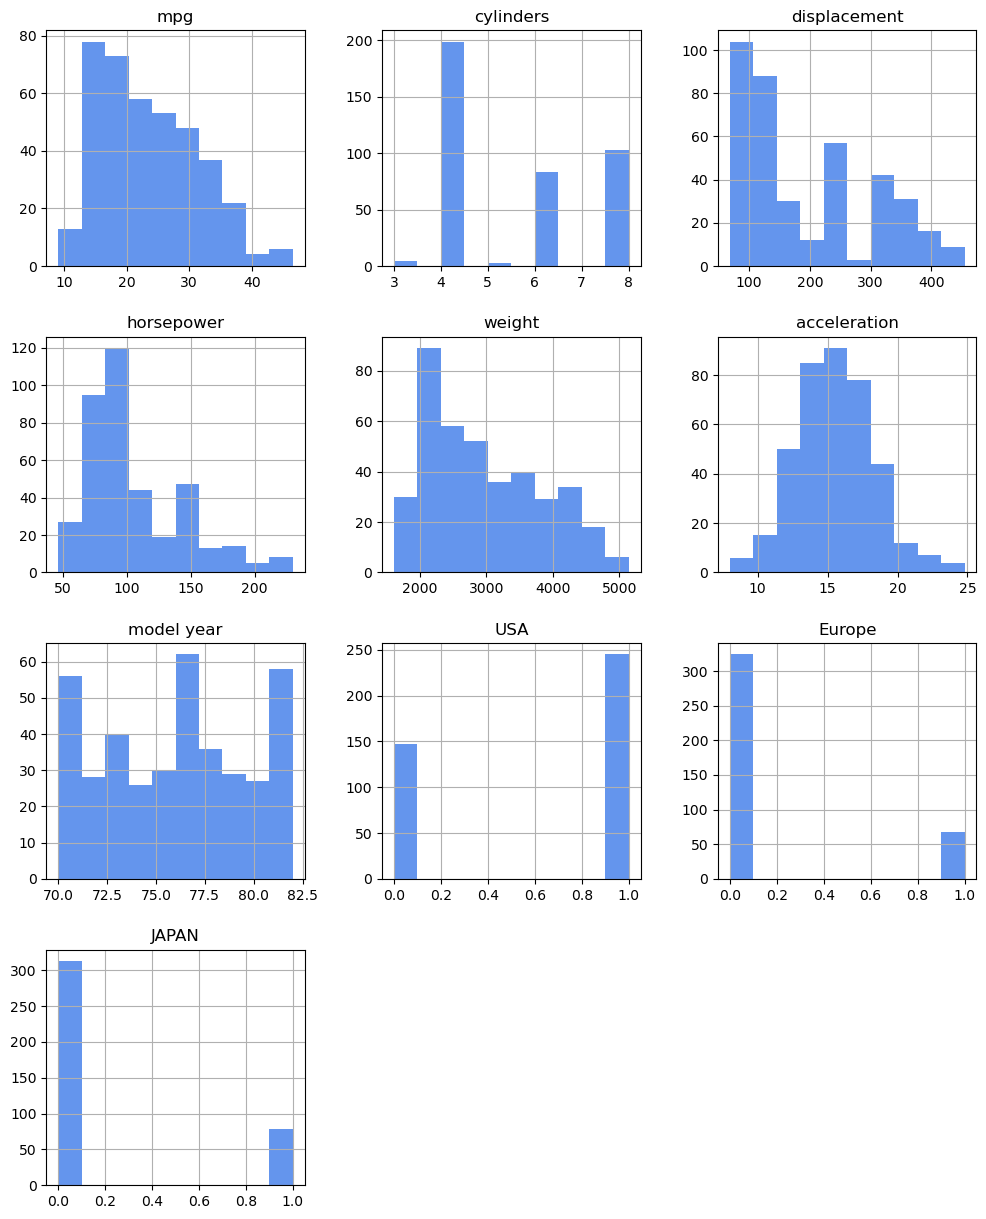

In [16]:
mpgDF.hist(figsize = (12, 15), color = 'cornflowerblue')
plt.show()

In [17]:
mpgDF.cylinders.value_counts()

cylinders
4    199
8    103
6     83
3      4
5      3
Name: count, dtype: int64

In [18]:
# cylinder 데이터 클래스가 불균형이므로 업샘플링

# 다수 클래스와 소수 클래스로 분리
majorityDF = mpgDF[mpgDF['cylinders'] == 4]

df = pd.DataFrame()
for i in [3, 5, 6, 8]:
    minorityDF = mpgDF[mpgDF['cylinders'] == i]
    # 소수 클래스 업샘플링
    upsampledDF = resample(minorityDF,
                           replace = True,   # 복제하여 샘플링
                           n_samples = len(majorityDF),    # 다수 클래스와 동일한 수로 샘플링
                           random_state = 42)  # 재현을 위한 랜덤 시드

    df = pd.concat([df, upsampledDF])

In [19]:
# 업샘플링이 되었는지 확인
upsampled_mpgDF = pd.concat([majorityDF, df])
upsampled_mpgDF['cylinders'].value_counts()

cylinders
4    199
3    199
5    199
6    199
8    199
Name: count, dtype: int64

### [2] 학습 데이터 준비 <hr>

In [20]:
X_train = upsampled_mpgDF.sample(frac = 0.8, random_state = 42)
X_test = upsampled_mpgDF.drop(X_train.index)
print(f'trainDF shape ==> {X_train.shape}\n testDF shape ==> {X_test.shape}')

trainDF shape ==> (796, 10)
 testDF shape ==> (56, 10)


In [21]:
y_train = X_train.pop('mpg')
y_test = X_test.pop('mpg')

In [22]:
train_stats = X_train.describe()
train_stats.transpose()

,count,mean,std,min,25%,50%,75%,max
cylinders,796.0,5.214824,1.739755,3.0,4.00,5.00,6.0,8.0
displacement,796.0,178.590452,101.377993,68.0,91.00,135.00,250.0,455.0
horsepower,796.0,103.878141,33.278379,46.0,79.75,100.00,110.0,225.0
weight,796.0,3027.487437,733.610284,1613.0,2420.00,2931.50,3530.0,4997.0
acceleration,796.0,15.547111,2.841858,8.0,13.50,15.25,17.4,24.8
model year,796.0,76.304020,3.501738,70.0,73.00,77.00,79.0,82.0
USA,796.0,0.452261,0.498029,0.0,0.00,0.00,1.0,1.0
Europe,796.0,0.267588,0.442980,0.0,0.00,0.00,1.0,1.0
JAPAN,796.0,0.280151,0.449355,0.0,0.00,0.00,1.0,1.0


In [23]:
ct = ColumnTransformer([('scaling', StandardScaler(), ['displacement', 'horsepower', 'weight', 'acceleration', 'model year'])], remainder = 'passthrough')
ct.fit(X_train)
scaled_X_train = ct.transform(X_train)
scaled_X_test = ct.transform(X_test)

In [24]:
mean = y_train.mean()
std = y_train.std()

scaled_y_train =(y_train - mean) / std
scaled_y_test = (y_test - mean) / std

### [3] 모델 생성 <hr>

In [25]:
# 순차적 모델 인스턴스 생성
mpgModel = Sequential(name = 'mpgMODEL')

In [26]:
# 입력층
mpgModel.add(Dense(10, input_shape=(9,), name='In'))
mpgModel.add(Activation('relu'))

# 은닉층
mpgModel.add(Dense(8, activation='relu', name='Hidd1'))
mpgModel.add(Dense(6, activation='relu', name='Hidd2'))
mpgModel.add(Dense(4, activation='relu', name='Hidd3'))
mpgModel.add(Dense(2, activation='relu', name='Hidd4'))

# 출력층
mpgModel.add(Dense(1, activation='linear', name='Out'))

In [27]:
mpgModel.summary()

Model: "mpgMODEL"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 In (Dense)                  (None, 10)                100       
                                                                 
 activation (Activation)     (None, 10)                0         
                                                                 
 Hidd1 (Dense)               (None, 8)                 88        
                                                                 
 Hidd2 (Dense)               (None, 6)                 54        
                                                                 
 Hidd3 (Dense)               (None, 4)                 28        
                                                                 
 Hidd4 (Dense)               (None, 2)                 10        
                                                                 
 Out (Dense)                 (None, 1)                 3  

In [28]:
# 모델을 컴파일합니다.
mpgModel.compile(loss = 'mse', 
              optimizer = 'adam', 
              metrics = ['mae', 'mse'])

In [29]:
# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시합니다
class PrintDot(callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: 
      print('')
    print('.', end = '')

### [4] 모델 학습 <hr>

In [30]:
EPOCHS = 500

history = mpgModel.fit(scaled_X_train, scaled_y_train,
                        epochs = EPOCHS, 
                        validation_split = 0.2, 
                        verbose = 0,
                        callbacks = [PrintDot()])
print(f'\n학습 종료')


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
학습 종료


In [31]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
495,0.038408,0.121816,0.038408,0.138726,0.196685,0.138726,495
496,0.037596,0.117482,0.037596,0.136545,0.183974,0.136545,496
497,0.037865,0.115178,0.037865,0.134117,0.191893,0.134117,497
498,0.038471,0.122564,0.038471,0.130485,0.189706,0.130485,498
499,0.037904,0.119781,0.037904,0.131467,0.192674,0.131467,499


In [32]:
prediction = mpgModel.predict(scaled_X_test)*std + mean
r2_score(prediction, y_test)

2/2 [==============================] - 0s 7ms/step


0.899761463901971

In [33]:
epochs, values = hist['epoch'].values, hist['mae'].values

In [34]:
import matplotlib.pyplot as plt

def plot_history():
    
    plt.figure(figsize=(10, 12))
    
    plt.subplot(2, 1, 1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error  [MAE]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label='Val Error')
    plt.ylim([0,5])
    plt.title("[MAE]")
    plt.legend()
    
    
    plt.subplot(2, 1, 2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MSE^2$]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label='Val Error')
    plt.ylim([0,5])
    plt.title("[$MSE^2$]")
    plt.legend()
    plt.show()

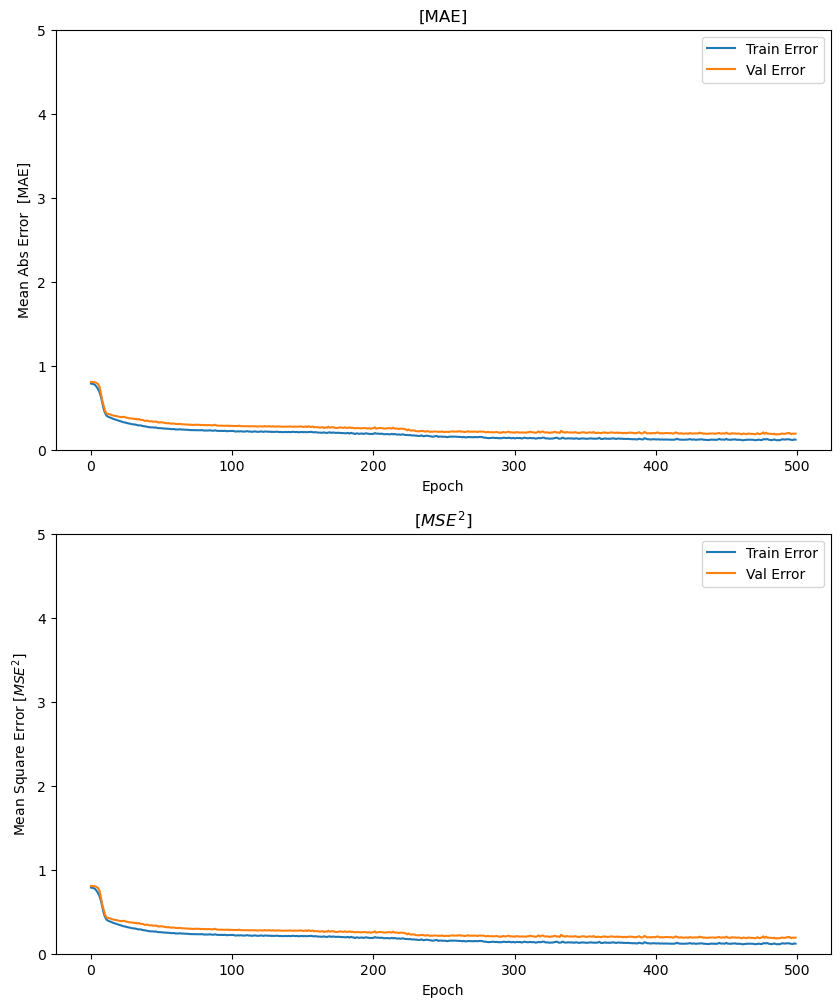

In [35]:
plot_history()

In [36]:
# patience 매개변수 : 성능 향상 체크할 에포크 횟수
EARLY_STOP = callbacks.EarlyStopping(monitor='val_loss', patience=10)
PRINT_DOT = PrintDot()
EPOCHS = 500

history = mpgModel.fit(scaled_X_train, scaled_y_train, 
                        epochs=EPOCHS,
                        validation_split = 0.2, 
                        verbose=0, 
                        callbacks=[EARLY_STOP, PRINT_DOT])


.................

In [37]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
12,0.037259,0.117474,0.037259,0.132413,0.183527,0.132413,12
13,0.037081,0.112461,0.037081,0.135628,0.186395,0.135628,13
14,0.037648,0.120256,0.037648,0.139183,0.192044,0.139183,14
15,0.037624,0.123277,0.037624,0.132345,0.188704,0.132345,15
16,0.037077,0.118285,0.037077,0.132150,0.192865,0.132150,16


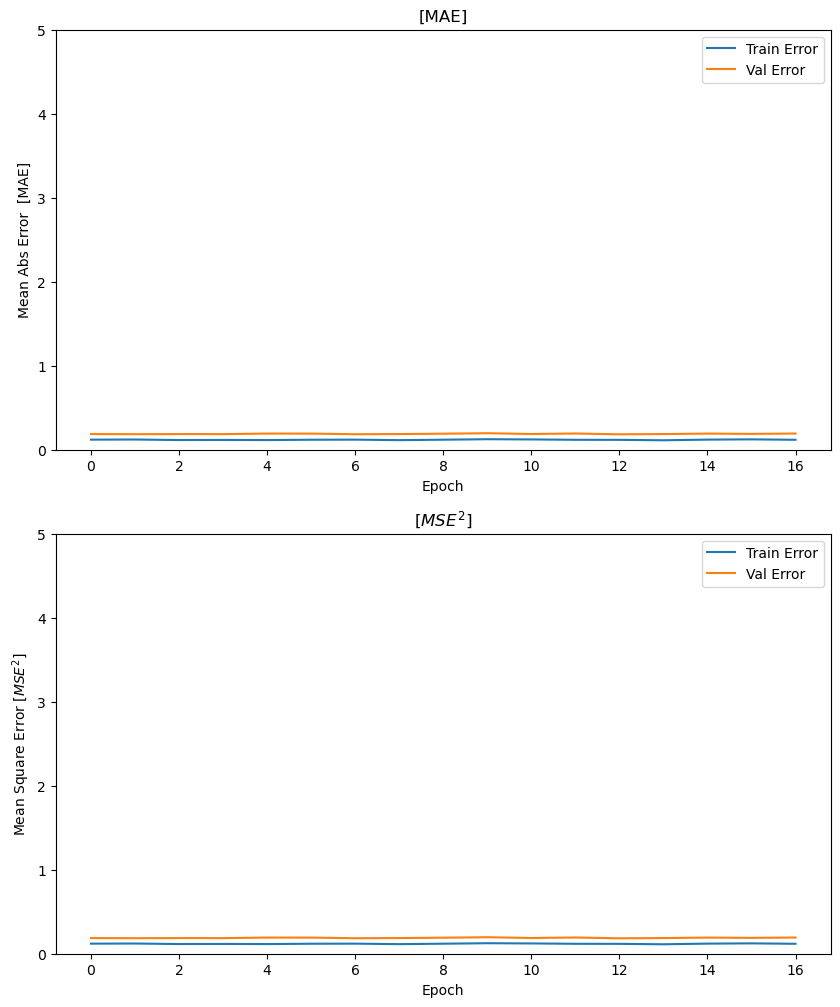

In [38]:
plot_history()

In [39]:
loss, mae, mse = mpgModel.evaluate(scaled_X_test, scaled_y_test, verbose=1)

print(f"\n테스트 세트의 손실 : {loss:5.2f}")
print(f"\n테스트 세트의 평균 절대 오차: {mae:5.2f}")
print(f"\n테스트 세트의 평균 제곱 오차: {mse:5.2f}")

2/2 [==============================] - 0s 4ms/step - loss: 0.0970 - mae: 0.2459 - mse: 0.0970

테스트 세트의 손실 :  0.10

테스트 세트의 평균 절대 오차:  0.25

테스트 세트의 평균 제곱 오차:  0.10


2/2 [==============================] - 0s 4ms/step
prediction : [[24.491674]
 [25.058167]
 [25.741358]
 [26.801888]
 [27.218683]
 [24.59955 ]
 [26.814299]
 [26.951609]
 [23.83917 ]
 [21.464094]
 [27.165396]
 [23.2271  ]
 [29.676033]
 [28.037699]
 [24.562515]
 [23.184277]
 [24.620853]
 [26.238888]
 [20.130287]
 [31.56361 ]
 [27.95753 ]
 [31.044056]
 [25.719103]
 [20.130287]
 [35.76539 ]
 [25.67562 ]
 [31.24428 ]
 [27.656693]
 [28.893297]
 [37.371666]
 [24.812153]
 [31.883507]
 [38.342873]
 [36.90341 ]
 [38.073673]
 [37.03927 ]
 [33.964504]
 [33.0941  ]
 [36.759857]
 [36.65297 ]
 [29.294027]
 [19.97598 ]
 [19.831165]
 [18.33204 ]
 [20.966648]
 [20.966648]
 [19.831165]
 [20.937685]
 [19.591259]
 [16.23973 ]
 [14.997748]
 [13.806431]
 [13.806431]
 [13.477004]
 [14.997748]
 [12.933207]]


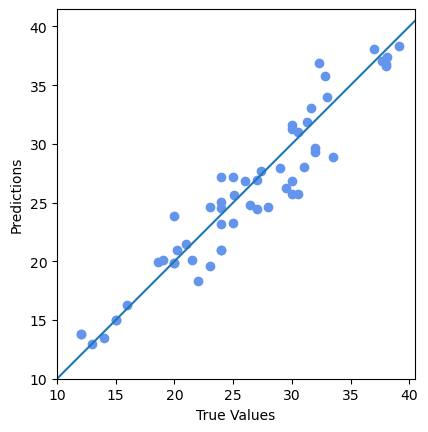

In [40]:
prediction = mpgModel.predict(scaled_X_test)*std + mean
print(f'prediction : {prediction}')

plt.scatter(y_test, prediction, color = 'cornflowerblue')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([10, plt.xlim()[1]])
plt.ylim([10, plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()